In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
random_seed= 42

In [5]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # gray scale for shape ?
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            y_label = torch.tensor(np.eye(self.nrofclass)[Category])
            #y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label]) # one hot encoding
           # img.close()

            
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2376.24it/s]


In [7]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

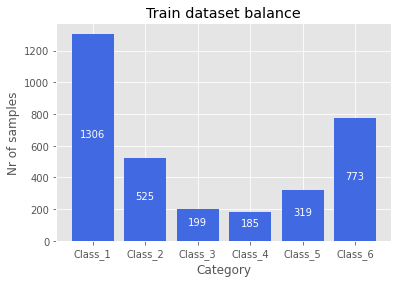

In [8]:
# Checking for class balance
DataSummary = []
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)
    
DataBalance = dict(zip(DataSetTrain.data.classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [9]:
# Initialise class weights
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain.data):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [10]:
#Data loaders
BATCH_SIZE = 50
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=True
                              )


In [11]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

class ParallelSum(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        return sum(map(lambda fn: fn(x), self.fns))

def Permutator(*, image_size, patch_size, dim, depth, num_classes, segments, expansion_factor = 4, dropout = 0.):
    assert (image_size % patch_size) == 0, 'image must be divisible by patch size'
    assert (dim % segments) == 0, 'dimension must be divisible by the number of segments'
    height = width = image_size // patch_size
    s = segments

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * 3, dim),
        *[nn.Sequential(
            PreNormResidual(dim, nn.Sequential(
                ParallelSum(
                    nn.Sequential(
                        Rearrange('b h w (c s) -> b w c (h s)', s = s),
                        nn.Linear(height * s, height * s),
                        Rearrange('b w c (h s) -> b h w (c s)', s = s),
                    ),
                    nn.Sequential(
                        Rearrange('b h w (c s) -> b h c (w s)', s = s),
                        nn.Linear(width * s, width * s),
                        Rearrange('b h c (w s) -> b h w (c s)', s = s),
                    ),
                    nn.Linear(dim, dim)
                ),
                nn.Linear(dim, dim)
            )),
            PreNormResidual(dim, nn.Sequential(
                nn.Linear(dim, dim * expansion_factor),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(dim * expansion_factor, dim),
                nn.Dropout(dropout)
            ))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b h w c -> b c', 'mean'),
        nn.Linear(dim, num_classes)
    )

In [12]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes)
    )

In [15]:
net = MLPMixer(
    image_size = 224,
    channels = 1,
    patch_size = 16,
    dim = 512,
    depth = 12,
    num_classes = 6
)
net.to(device)

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
  (1): Linear(in_features=256, out_features=512, bias=True)
  (2): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(
        (0): Conv1d(196, 784, kernel_size=(1,), stride=(1,))
        (1): GELU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Conv1d(784, 196, kernel_size=(1,), stride=(1,))
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNormResidual(
      (fn): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): GELU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (3): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(
        (0): Conv1d(196, 784, ker

In [17]:
EPOCHS = 10
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
steps = len(train_data_loader)
stepsv = len(valid_data_loader)
#val_losses = []
#train_losses = []
#val_accs = []
#train_accs = []
net.to(device)
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y.max(1).indices).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels.max(1).indices).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.97it/s]


Epoch: 0. Loss: 0.043084991542651344. Validation Loss: 0.2836516632128021
Train accuracy: 95.31343283582089. Validation accuracy: 75.9090909090909


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.17it/s]


Epoch: 1. Loss: 0.040065196450818595. Validation Loss: 0.21584894860128595
Train accuracy: 95.67164179104478. Validation accuracy: 81.36363636363636


  7%|██████▏                                                                            | 5/67 [00:01<00:21,  2.86it/s]


KeyboardInterrupt: 

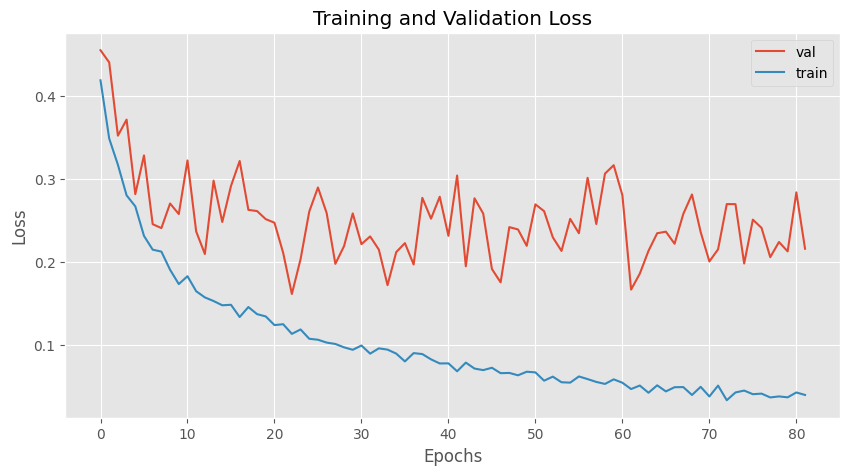

In [21]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

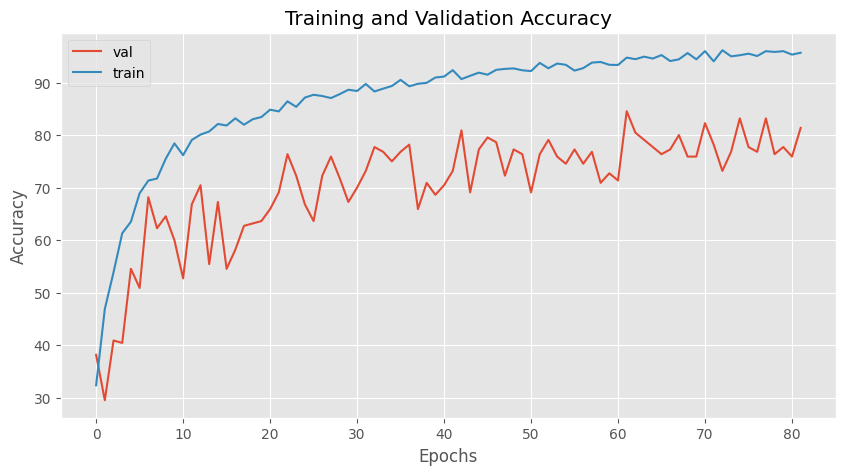

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
net.eval()
net.cuda()
confusion_matrix = torch.zeros(6, 6, dtype=torch.int32)
with torch.no_grad():
    for i in tqdm(range(len(DataSetTest))):
        real_class = torch.argmax(DataSetTest[i][1].to('cuda'))
        x = DataSetTest[i][0]
        x = x.unsqueeze(0)
        net_out = net(x.to('cuda'))[0] 
        predicted_class = torch.argmax(net_out)        
        #print (predicted_class.item(),real_class.item())        
        if predicted_class == real_class:
            correct += 1
        total += 1
        for t, p in zip(real_class.view(-1), predicted_class.view(-1)):
                confusion_matrix[t, p] += 1
print("Accuracy: ", round(correct/total, 10))

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    net.eval()
    net.cpu()
    total = 0
    for inputs, labels in test_data_loader:
           
            
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.max(1).indices.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.max(1).indices.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.8344671130180359


In [19]:
print("Accuracy: ", 100*(correct/total).item())

Accuracy:  83.44671130180359


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    net.eval()
    net.cpu()
    total = 0
    for inputs, labels in test_data_loader:
           
            
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.max(1).indices.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.max(1).indices.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.7698412537574768


Confusion matrix, without normalization
[[334   0   3   9   0  15]
 [ 30  94  12   1   0   5]
 [  3   3  34   2   3   8]
 [  1   0   1  41   0   3]
 [  0   0   0   0  85   3]
 [ 13   0   9  11  11 148]]


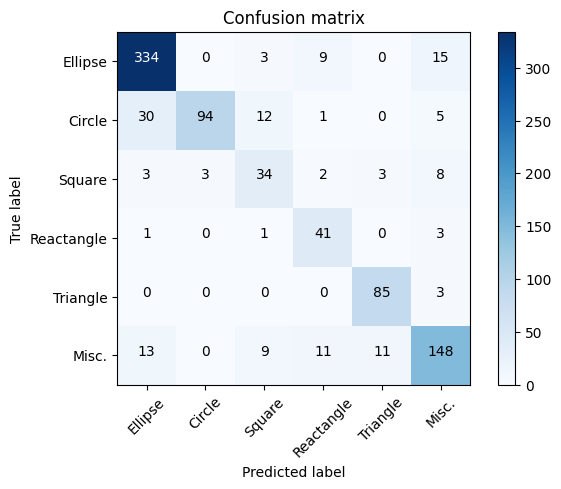

In [20]:
Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, Classes)

In [24]:
from torchsummary import summary
summary(net.cuda(), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 196, 256]               0
            Linear-2             [-1, 196, 512]         131,584
         LayerNorm-3             [-1, 196, 512]           1,024
            Conv1d-4             [-1, 784, 512]         154,448
              GELU-5             [-1, 784, 512]               0
           Dropout-6             [-1, 784, 512]               0
            Conv1d-7             [-1, 196, 512]         153,860
           Dropout-8             [-1, 196, 512]               0
   PreNormResidual-9             [-1, 196, 512]               0
        LayerNorm-10             [-1, 196, 512]           1,024
           Linear-11             [-1, 196, 256]         131,328
             GELU-12             [-1, 196, 256]               0
          Dropout-13             [-1, 196, 256]               0
           Linear-14             [-1, 1